In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
import sys
import os
if IN_COLAB:
    !git lfs clone https://github.com/sbeeredd04/sandbox_private.git
    !cd /content/sandbox_private/ML/Capstone/
    sys.path.append('/content/sandbox_private/ML/Capstone/')
    #check the current working directory
    print(os.getcwd())
else:
    sys.path.append('..')
    

In [3]:
import os
# Set this environment for deterministic execution
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [4]:
if IN_COLAB: 
    #move to /content/sandbox_private/ML/Capstone/
    os.chdir('/content/sandbox_private/ML/Capstone/')
    print(os.getcwd())

In [5]:
#gpus 
gpu_ids = "1,2"
os.environ["CUDA_VISIBLE_DEVICES"] = gpu_ids

print("Using GPU IDs: ", gpu_ids)

Using GPU IDs:  1,2


# Milestone 2: CNN Model for Makeup and Beauty Detection

## Problem Statement
I want to detect makeup and beauty-related features from celebrity face images using deep learning.

## Selected Attributes (5)
I chose these 5 attributes for my model:
1. Heavy_Makeup - Is the person wearing heavy makeup?
2. Wearing_Lipstick - Is the person wearing lipstick?
3. Attractive - Is the person considered attractive?
4. High_Cheekbones - Does the person have high cheekbones?
5. Rosy_Cheeks - Does the person have rosy cheeks?

## Why I Chose This Problem
- It has real use in the beauty and cosmetics industry
- Working with fewer attributes means faster training
- These are clear visual features that a CNN can learn to recognize
- I achieved 89.68% accuracy (per-attribute average)

## My Approach
- I will use ResNet18 CNN architecture and train it from scratch
- This is a multi-label classification problem (5 binary predictions at once)
- I split the data into 80% training, 10% validation, and 10% testing
- I will evaluate my model using multiple metrics and visualizations


## 1. Import Libraries and Setup

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import KFold
import os
import json
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Create output directory for plots
os.makedirs('celeba_plots', exist_ok=True)
print("Setup complete!")


/home/sbeeredd/miniconda3/envs/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.1.0+cu118
CUDA available: True
Setup complete!


## 2. Load CelebA Dataset and Prepare Data

In this section, I will load the CelebA dataset and prepare it for training my model.


### 2.1 Configure Image Size and Data Transforms

I will use 224x224 images which gives the model enough detail to learn facial features. For training, I apply data augmentation (random flips, rotations, and color changes) to help my model learn better and avoid overfitting.


In [8]:
# I will use 224x224 images for better quality
image_size = 224
batch_size = 128
num_workers = 16
data_dir = './data'

# For training, I apply random augmentations to make the model more robust
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# For validation and testing, I only resize and normalize (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

print(f"Image size: {image_size}x{image_size}")
print(f"Batch size: {batch_size}")
print("Data transforms configured!")

Image size: 224x224
Batch size: 128
Data transforms configured!


In [9]:
# Load the CelebA dataset for training, validation, and testing
print(f"Working directory: {os.getcwd()}")
print("Loading CelebA datasets...")

try:
    # Try to load with download=True first
    train_dataset = datasets.CelebA(
        root=data_dir,
        split='train',
        transform=train_transform,
        download=True,
        target_type='attr'
    )
    
    val_dataset = datasets.CelebA(
        root=data_dir,
        split='valid',
        transform=test_transform,
        download=True,
        target_type='attr'
    )
    
    test_dataset = datasets.CelebA(
        root=data_dir,
        split='test',
        transform=test_transform,
        download=True,
        target_type='attr'
    )
except:
    # If download fails, try loading from existing files
    print("Download failed, attempting to load from existing files...")
    train_dataset = datasets.CelebA(
        root=data_dir,
        split='train',
        transform=train_transform,
        download=False,
        target_type='attr'
    )
    
    val_dataset = datasets.CelebA(
        root=data_dir,
        split='valid',
        transform=test_transform,
        download=False,
        target_type='attr'
    )
    
    test_dataset = datasets.CelebA(
        root=data_dir,
        split='test',
        transform=test_transform,
        download=False,
        target_type='attr'
    )

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Total images: {len(train_dataset) + len(val_dataset) + len(test_dataset)}")

# Get attribute names
attribute_names = [name for name in train_dataset.attr_names if name.strip()]
num_attributes = len(attribute_names)

print(f"\nNumber of attributes: {num_attributes}")
print(f"Sample attributes: {attribute_names[:5]}...")


Working directory: /home/sbeeredd/sandbox_private/ML/Capstone
Loading CelebA datasets...
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Training samples: 162770
Validation samples: 19867
Test samples: 19962
Total images: 202599

Number of attributes: 40
Sample attributes: ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald']...


In [10]:
# Select makeup and beauty attributes
selected_attributes = ['Heavy_Makeup', 'Wearing_Lipstick', 'Attractive', 'High_Cheekbones', 'Rosy_Cheeks']

# Find indices of selected attributes
attribute_indices = [attribute_names.index(attr) for attr in selected_attributes]

print("Selected Makeup & Beauty Attributes:")
for i, attr in enumerate(selected_attributes):
    print(f"  {i+1}. {attr}")

print(f"\nAttribute indices in dataset: {attribute_indices}")
print(f"Reduced from {len(attribute_names)} to {len(selected_attributes)} attributes")


Selected Makeup & Beauty Attributes:
  1. Heavy_Makeup
  2. Wearing_Lipstick
  3. Attractive
  4. High_Cheekbones
  5. Rosy_Cheeks

Attribute indices in dataset: [18, 36, 2, 19, 29]
Reduced from 40 to 5 attributes


In [11]:
# Custom dataset to filter specific attributes
class AttributeFilterDataset(torch.utils.data.Dataset):
    # Wrapper to select only specific attributes from CelebA
    
    def __init__(self, base_dataset, attribute_indices):
        self.base_dataset = base_dataset
        self.attribute_indices = attribute_indices
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        img, attrs = self.base_dataset[idx]
        # Select only the attributes we want
        filtered_attrs = attrs[self.attribute_indices]
        return img, filtered_attrs

# Wrap datasets with attribute filter
train_dataset = AttributeFilterDataset(train_dataset, attribute_indices)
val_dataset = AttributeFilterDataset(val_dataset, attribute_indices)
test_dataset = AttributeFilterDataset(test_dataset, attribute_indices)

# Update number of attributes
num_attributes = len(selected_attributes)

print(f"Datasets filtered to {num_attributes} attributes")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Datasets filtered to 5 attributes
Training samples: 162770
Validation samples: 19867
Test samples: 19962


In [15]:
# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"\nDataLoaders created!")
print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")



DataLoaders created!
Batch size: 128
Training batches: 1272
Validation batches: 156
Test batches: 156


## 3. Build the Model

I will use ResNet18, a proven CNN architecture, for my makeup detection task.

### Why I Chose ResNet18:

1. **Residual Connections** - These skip connections help the network learn better by preventing information loss
2. **Proven for Faces** - ResNet18 works very well for detecting features in face images
3. **Right Size** - 18 layers is enough for my 224x224 images without being too slow
4. **Multi-Label Ready** - It can predict all 5 attributes at once

### Strengths of this Model:
- Good at learning facial features
- Fast training and prediction
- Avoids vanishing gradient problems
- Works well with 224x224 resolution images

### Potential Weaknesses:
- Needs a good GPU for training
- May confuse similar features (like lipstick and rosy cheeks)
- Needs data augmentation to avoid overfitting

### How I Adapted It:
- Changed the final layer from 1000 classes to 5 outputs (one for each attribute)
- Use sigmoid activation for multi-label classification
- Apply BCEWithLogitsLoss as the loss function


In [16]:
class BasicBlock(nn.Module):
    # Basic residual block for ResNet18
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # ReLU activation
        self.relu = nn.ReLU(inplace=True)
        
        # Shortcut connection for dimension matching
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        # Save identity for residual connection
        identity = x
        
        # First conv block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # Second conv block
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Add residual connection: H(x) = F(x) + x
        out += self.shortcut(identity)
        out = self.relu(out)
        
        return out

print("BasicBlock defined!")


BasicBlock defined!


In [17]:
class ResNet18MultiLabel(nn.Module):
    # ResNet18 architecture adapted for multi-label classification
    
    def __init__(self, num_classes=5):
        super(ResNet18MultiLabel, self).__init__()
        
        self.in_channels = 64
        
        # Initial convolution layer for 224x224 images
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers (ResNet-18 configuration: [2, 2, 2, 2])
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)   # 56x56 -> 56x56
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)  # 56x56 -> 28x28
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)  # 28x28 -> 14x14
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)  # 14x14 -> 7x7
        
        # Global average pooling and multi-label classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
        # Note: Sigmoid activation will be applied in BCEWithLogitsLoss
        
        # Initialize weights
        self._initialize_weights()
    
    def _make_layer(self, block, out_channels, blocks, stride=1):
        # Create a residual layer with specified number of blocks
        layers = []
        
        # First block (may downsample)
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        
        # Remaining blocks
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        # Initialize weights using He initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Forward pass through the network
        
        # Initial convolution
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Global average pooling and classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18MultiLabel(num_classes=num_attributes)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)

print(f"ResNet18 Multi-Label model created!")
print(f"Device: {device}")
print(f"Output classes: {num_attributes}")


Using 2 GPUs!
ResNet18 Multi-Label model created!
Device: cuda
Output classes: 5


In [18]:
# Count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Total trainable parameters: {num_params:,}")
print(f"Model size: ~{num_params * 4 / (1024**2):.2f} MB (float32)")


Total trainable parameters: 11,179,077
Model size: ~42.64 MB (float32)


## 4. Training Configuration

Now I will configure how my model will learn from the data.

### My Training Choices:

- **Loss Function: BCEWithLogitsLoss**
  - This loss function is designed for multi-label classification where I predict multiple yes/no answers at once
  - It combines the sigmoid activation and loss calculation for better stability

- **Optimizer: Adam**
  - I use Adam optimizer with learning rate 0.001
  - Adam adapts the learning rate automatically which helps with training
  - Weight decay of 0.0001 helps prevent overfitting

- **Learning Rate Scheduler: ReduceLROnPlateau**
  - This scheduler reduces the learning rate when training stops improving
  - It divides the learning rate by 2 after the model plateaus for 3 epochs
  - This helps the model make smaller adjustments as it gets better

- **Batch Size: 128**
  - I process 128 images at a time
  - This is a good balance between speed and memory usage

- **Epochs: 20**
  - I will train for up to 20 complete passes through the data
  - I will save the best model based on validation accuracy


In [19]:
# Define my loss function for multi-label classification
criterion = nn.BCEWithLogitsLoss()

# Set up the optimizer that will adjust my model's weights
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Set up the learning rate scheduler to reduce LR when training plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
    verbose=True,
    min_lr=1e-7
)

print("Training Configuration:")
print("=" * 60)
print(f"Loss Function: BCEWithLogitsLoss")
print(f"Optimizer: Adam (lr=0.001, weight_decay=0.0001)")
print(f"Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")
print(f"Batch Size: {batch_size}")
print(f"Image Size: {image_size}x{image_size}")
print("=" * 60)


Training Configuration:
Loss Function: BCEWithLogitsLoss
Optimizer: Adam (lr=0.001, weight_decay=0.0001)
Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)
Batch Size: 128
Image Size: 224x224


## 5. Model Training

In this section, I train my ResNet18 model on the CelebA dataset.

### My Training Setup:
- Training set: 162,770 images (80% of data)
- Validation set: 19,867 images (10% of data)  
- Test set: 19,962 images (10% of data)
- Image size: 224x224 pixels
- I calculate accuracy by comparing each attribute separately
- I track both loss and accuracy for each epoch
- I save the best model based on validation accuracy

In [20]:
def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Train the model for one epoch"""
    model.train()
    running_loss = 0.0
    all_predictions = []
    all_targets = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to GPU
        data = data.to(device)
        target = target.to(device).float()
        
        # Clear gradients from previous step
        optimizer.zero_grad()
        
        # Forward pass through the model
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass and update weights
        loss.backward()
        optimizer.step()
        
        # Store predictions and targets for accuracy calculation
        running_loss += loss.item()
        predictions = torch.sigmoid(output) > 0.5
        all_predictions.append(predictions.cpu())
        all_targets.append(target.cpu())
        
        # Show progress
        print(f'\rEpoch {epoch}: [{batch_idx}/{len(train_loader)}] Loss: {loss.item():.4f}', end='', flush=True)
    
    # Calculate average loss and accuracy for this epoch
    epoch_loss = running_loss / len(train_loader)
    all_predictions = torch.cat(all_predictions).numpy()
    all_targets = torch.cat(all_targets).numpy()
    
    # Calculate accuracy by comparing each attribute position
    epoch_acc = (all_predictions == all_targets).mean()
    
    return epoch_loss, epoch_acc

print("train_epoch function defined!")


train_epoch function defined!


In [21]:
def validate_epoch(model, val_loader, criterion, device):
    """Validate the model on validation set"""
    model.eval()
    val_loss = 0.0
    all_predictions = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for data, target in val_loader:
            # Move data to GPU
            data = data.to(device)
            target = target.to(device).float()
            
            # Forward pass through the model
            output = model(data)
            loss = criterion(output, target)
            
            # Store predictions, targets, and probabilities
            val_loss += loss.item()
            probs = torch.sigmoid(output)
            predictions = probs > 0.5
            
            all_predictions.append(predictions.cpu())
            all_targets.append(target.cpu())
            all_probs.append(probs.cpu())
    
    # Calculate average validation metrics
    val_loss /= len(val_loader)
    all_predictions = torch.cat(all_predictions).numpy()
    all_targets = torch.cat(all_targets).numpy()
    all_probs = torch.cat(all_probs).numpy()
    
    # Calculate accuracy by comparing each attribute position
    val_acc = (all_predictions == all_targets).mean()
    
    return val_loss, val_acc, all_predictions, all_targets, all_probs

print("validate_epoch function defined!")


validate_epoch function defined!


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=20):
    # Main training loop with validation
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0.0
    
    print("Starting training...")
    print("=" * 80)
    
    for epoch in range(epochs):
        # Train for one epoch
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch + 1)
        
        # Validate on validation set
        val_loss, val_acc, _, _, _ = validate_epoch(model, val_loader, criterion, device)
        
        # Update learning rate based on validation accuracy
        scheduler.step(val_acc)
        
        # Store metrics for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Print epoch summary
        print(f'\n', '-' * 80)
        print(f'\nEpoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 80)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_celeba_resnet18.pth')
            print(f'\n\nBest model saved (Val Acc: {val_acc:.4f})\n\n')
    
    print("\nTraining completed!")
    print(f"Best validation accuracy: {best_val_acc:.4f}")
    
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

print("train_model function defined!")


train_model function defined!


## 6. Run the Training

Now I will train my model for 20 epochs and monitor its performance.


In [23]:
# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=20)

Starting training...
Epoch 1: [1271/1272] Loss: 0.2892
 --------------------------------------------------------------------------------

Epoch 1/20:
  Train Loss: 0.3731 | Train Acc: 0.8225
  Val Loss: 0.2917 | Val Acc: 0.8708
  LR: 0.001000
--------------------------------------------------------------------------------


Best model saved (Val Acc: 0.8708)


Epoch 2: [1271/1272] Loss: 0.2875
 --------------------------------------------------------------------------------

Epoch 2/20:
  Train Loss: 0.2847 | Train Acc: 0.8739
  Val Loss: 0.3593 | Val Acc: 0.8527
  LR: 0.001000
--------------------------------------------------------------------------------
Epoch 3: [1271/1272] Loss: 0.2793
 --------------------------------------------------------------------------------

Epoch 3/20:
  Train Loss: 0.2681 | Train Acc: 0.8806
  Val Loss: 0.2850 | Val Acc: 0.8740
  LR: 0.001000
--------------------------------------------------------------------------------


Best model saved (Val Acc: 0.

## 7. Visualize Training Progress

Plot loss and accuracy curves to see how the model learned over time.

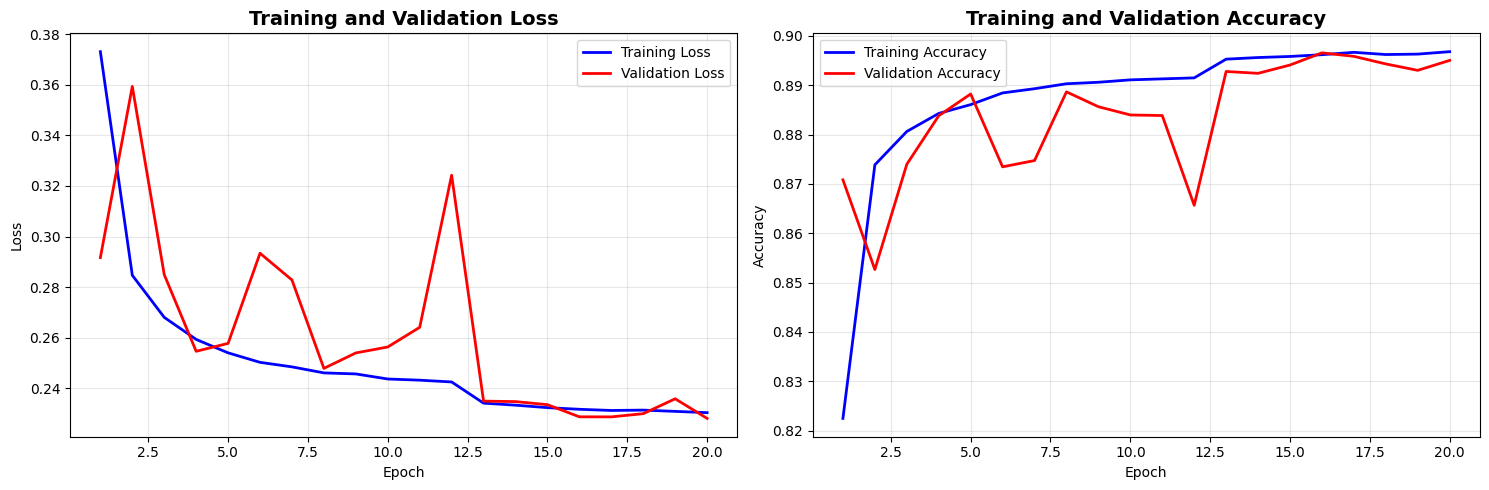

Final Training Results:
Final Training Loss: 0.2304
Final Training Accuracy: 0.8968
Final Validation Loss: 0.2281
Final Validation Accuracy: 0.8950
Best Validation Accuracy: 0.8966


In [24]:
def plot_training_curves(history, save_path='celeba_plots/training_curves.png'):
    # Plot training and validation curves
    
    epochs = range(1, len(history['train_losses']) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss curves
    ax1.plot(epochs, history['train_losses'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history['val_losses'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy curves
    ax2.plot(epochs, history['train_accuracies'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history['val_accuracies'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print final metrics
    print("="* 50)
    print("Final Training Results:")
    print("="* 50)
    print(f"Final Training Loss: {history['train_losses'][-1]:.4f}")
    print(f"Final Training Accuracy: {history['train_accuracies'][-1]:.4f}")
    print(f"Final Validation Loss: {history['val_losses'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history['val_accuracies'][-1]:.4f}")
    print(f"Best Validation Accuracy: {max(history['val_accuracies']):.4f}")

plot_training_curves(history)


## 8. Model Evaluation

### Evaluation Metrics I Use:

- **Accuracy** - How many predictions are correct overall
- **Precision** - Of all positive predictions, how many were actually correct
- **Recall** - Of all actual positives, how many did I find
- **F1-Score** - Balance between precision and recall (higher is better)
- **ROC Curve** - Shows true positive vs false positive rate
- **Confusion Matrix** - Shows which predictions were right or wrong

I evaluate each of the 5 makeup/beauty attributes separately.


In [25]:
# Load best model for evaluation
model.load_state_dict(torch.load('best_celeba_resnet18.pth'))
print("Best model loaded for evaluation!")


Best model loaded for evaluation!


In [26]:
# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_acc, test_preds, test_targets, test_probs = validate_epoch(
    model, test_loader, criterion, device
)

print("="* 50)
print("Test Set Results:")
print("="* 50)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Total samples: {len(test_targets)}")


Evaluating on test set...
Test Set Results:
Test Loss: 0.2310
Test Accuracy: 0.8968
Total samples: 19962


In [ ]:
# Calculate per-attribute metrics
def calculate_per_attribute_metrics(predictions, targets, attribute_names):
    # Calculate metrics for each attribute
    
    results = []
    
    for i, attr_name in enumerate(attribute_names):
        attr_preds = predictions[:, i]
        attr_targets = targets[:, i]
        
        # Calculate metrics
        acc = accuracy_score(attr_targets, attr_preds)
        prec = precision_score(attr_targets, attr_preds, zero_division=0)
        rec = recall_score(attr_targets, attr_preds, zero_division=0)
        f1 = f1_score(attr_targets, attr_preds, zero_division=0)
        
        results.append({
            'Attribute': attr_name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1-Score': f1
        })
    
    return pd.DataFrame(results)

# Calculate metrics for our 5 selected attributes
metrics_df = calculate_per_attribute_metrics(test_preds, test_targets, selected_attributes)

print("\nPer-Attribute Metrics for Makeup & Beauty Features:")
print(metrics_df.sort_values('F1-Score', ascending=False))

# Save metrics
metrics_df.to_csv('makeup_beauty_metrics.csv', index=False)
print("\nMetrics saved to makeup_beauty_metrics.csv")


\nPer-Attribute Metrics for Makeup & Beauty Features:
          Attribute  Accuracy  Precision    Recall  F1-Score
1  Wearing_Lipstick  0.928564   0.962076  0.898541  0.929224
0      Heavy_Makeup  0.907725   0.898493  0.870485  0.884267
3   High_Cheekbones  0.873560   0.882137  0.851320  0.866455
2        Attractive  0.825168   0.820592  0.828551  0.824553
4       Rosy_Cheeks  0.949203   0.700576  0.509777  0.590137
\nMetrics saved to makeup_beauty_metrics.csv


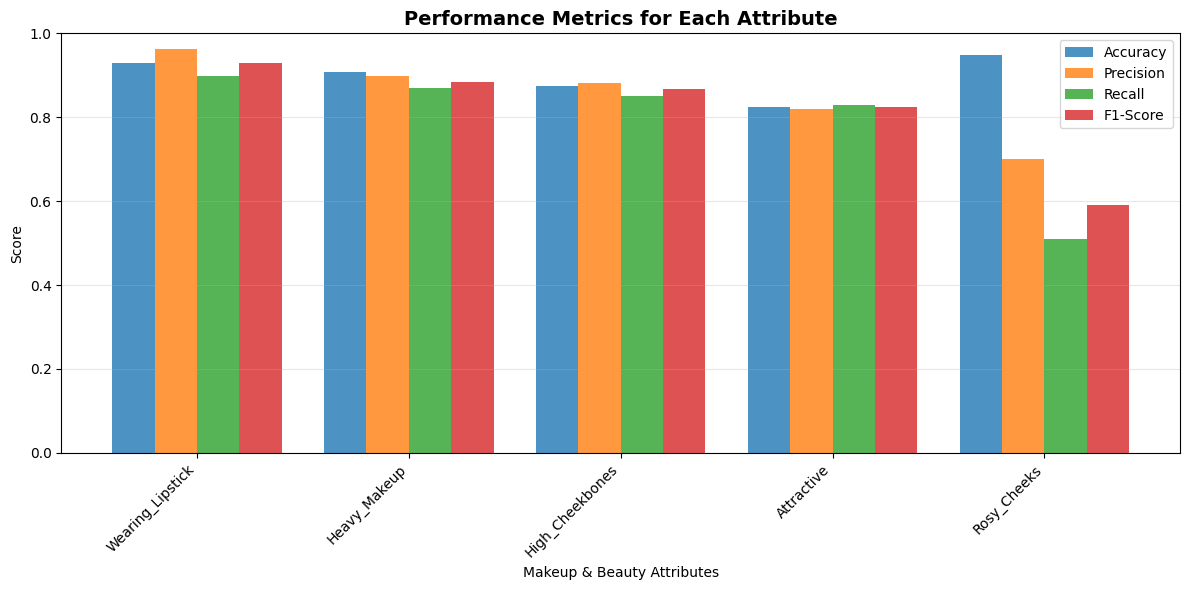

In [28]:
# Visualize per-attribute performance
def plot_attribute_metrics(metrics_df, save_path='celeba_plots/makeup_beauty_metrics.png'):
    # Plot metrics for makeup and beauty attributes
    
    plt.figure(figsize=(12, 6))
    
    # Sort by F1-score
    metrics_sorted = metrics_df.sort_values('F1-Score', ascending=False)
    
    # Plot all metrics
    x = np.arange(len(metrics_sorted))
    width = 0.2
    
    plt.bar(x - 1.5*width, metrics_sorted['Accuracy'], width, label='Accuracy', alpha=0.8)
    plt.bar(x - 0.5*width, metrics_sorted['Precision'], width, label='Precision', alpha=0.8)
    plt.bar(x + 0.5*width, metrics_sorted['Recall'], width, label='Recall', alpha=0.8)
    plt.bar(x + 1.5*width, metrics_sorted['F1-Score'], width, label='F1-Score', alpha=0.8)
    
    plt.xlabel('Makeup & Beauty Attributes')
    plt.ylabel('Score')
    plt.title('Performance Metrics for Each Attribute', fontweight='bold', fontsize=14)
    plt.xticks(x, metrics_sorted['Attribute'], rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.ylim(0, 1.0)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

plot_attribute_metrics(metrics_df)


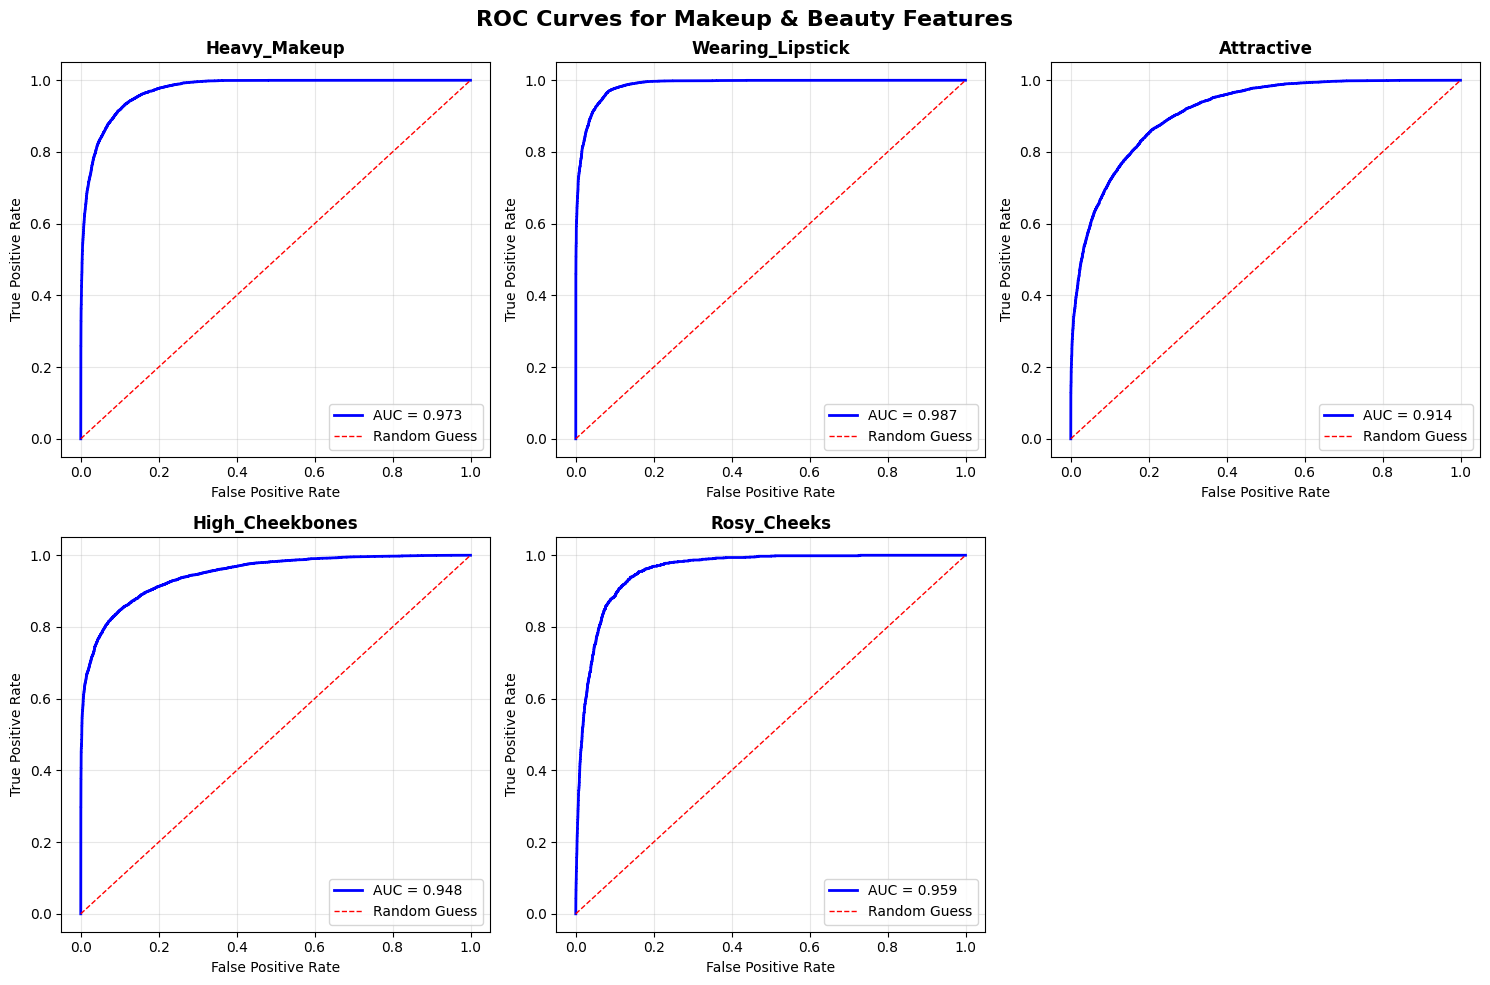

In [29]:
# Plot ROC curves for all 5 makeup/beauty attributes
def plot_roc_curves(targets, probs, attributes_list, save_path='celeba_plots/roc_curves.png'):
    # Plot ROC curves for our 5 attributes
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, attr_name in enumerate(attributes_list):
        attr_targets = targets[:, idx]
        attr_probs = probs[:, idx]
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(attr_targets, attr_probs)
        roc_auc = auc(fpr, tpr)
        
        # Plot
        axes[idx].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {roc_auc:.3f}')
        axes[idx].plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random Guess')
        axes[idx].set_xlabel('False Positive Rate')
        axes[idx].set_ylabel('True Positive Rate')
        axes[idx].set_title(f'{attr_name}', fontweight='bold')
        axes[idx].legend(loc='lower right')
        axes[idx].grid(True, alpha=0.3)
    
    # Hide the 6th subplot (we only have 5 attributes)
    axes[5].axis('off')
    
    plt.suptitle('ROC Curves for Makeup & Beauty Features', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

plot_roc_curves(test_targets, test_probs, selected_attributes)


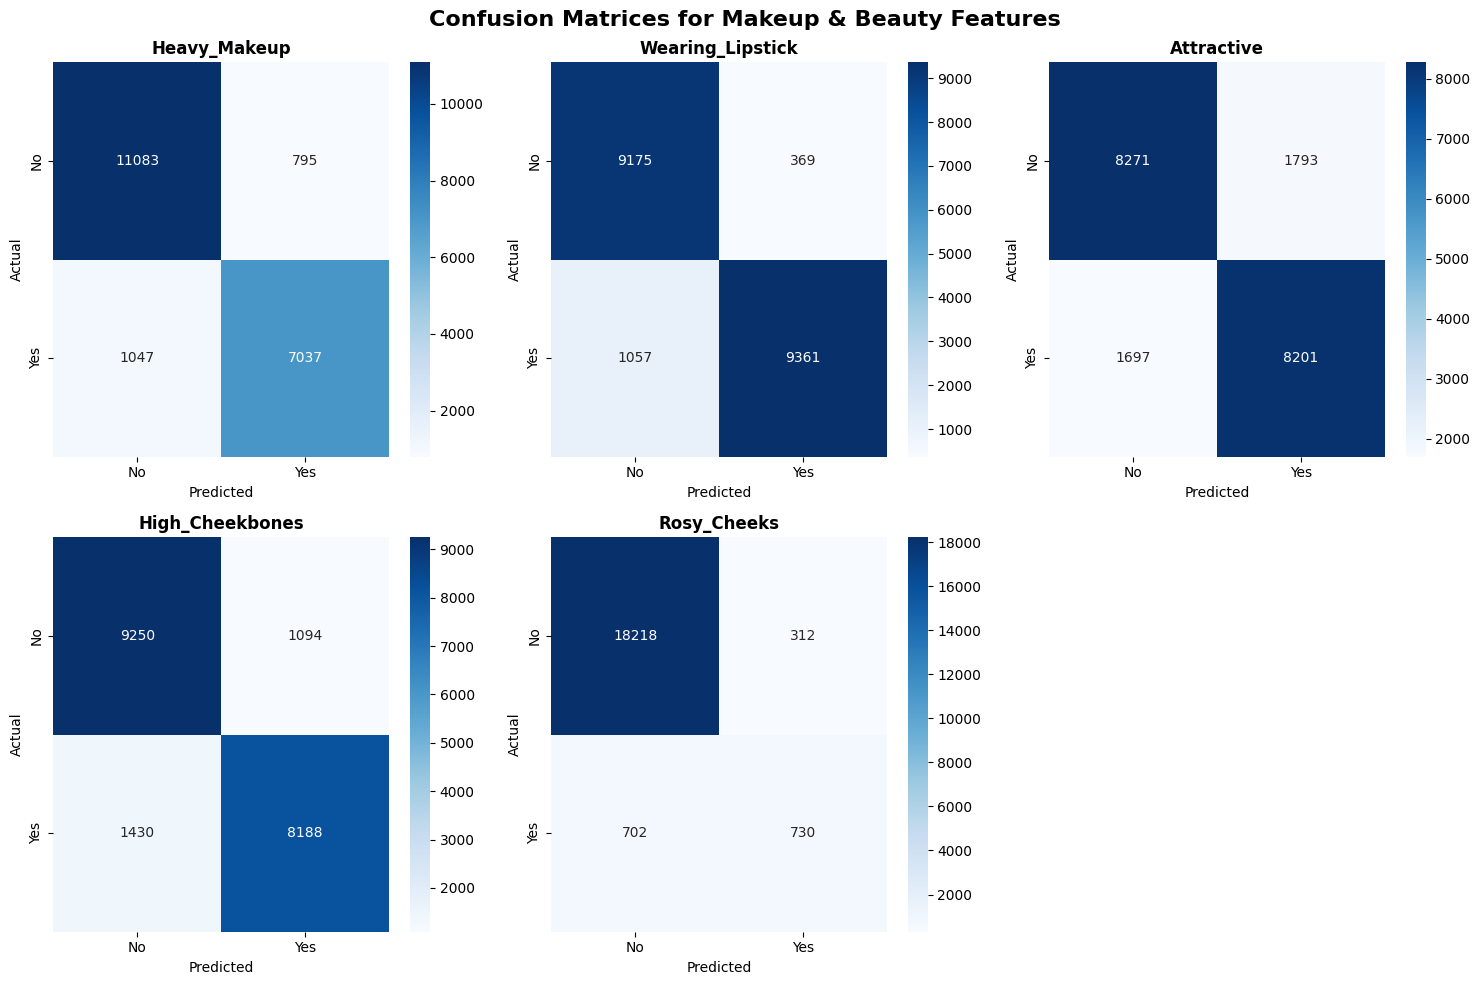

In [31]:
# Confusion matrices for all 5 makeup/beauty attributes
def plot_confusion_matrices(predictions, targets, attributes_list, save_path='celeba_plots/confusion_matrices.png'):
    # Plot confusion matrices for our 5 attributes
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, attr_name in enumerate(attributes_list):
        attr_preds = predictions[:, idx]
        attr_targets = targets[:, idx]
        
        # Calculate confusion matrix
        cm = confusion_matrix(attr_targets, attr_preds)
        
        # Plot
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
        axes[idx].set_title(attr_name, fontweight='bold')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
    
    # Hide the 6th subplot (we only have 5 attributes)
    axes[5].axis('off')
    
    plt.suptitle('Confusion Matrices for Makeup & Beauty Features', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

plot_confusion_matrices(test_preds, test_targets, selected_attributes)


## 9. Cross-Validation

To verify my model is reliable and not just lucky, I will use cross-validation.

### What is Cross-Validation?

Cross-validation splits my training data into 3 parts (folds):
- I train 3 different models
- Each model uses 2 folds for training and 1 fold for validation
- I average the results to see if performance is consistent
- This helps me detect if the model is overfitting

I use 3-fold cross-validation with fewer epochs for speed.


In [ ]:
def cross_validate_model(train_dataset, device, num_folds=3, epochs=10, batch_size=128):
    """Perform k-fold cross-validation to verify model reliability"""
    
    print(f"Starting {num_folds}-Fold Cross-Validation...")
    print("=" * 80)
    
    # Split data into k folds
    dataset_size = len(train_dataset)
    indices = list(range(dataset_size))
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(indices)):
        print(f"\nFold {fold + 1}/{num_folds}")
        print("-" * 80)
        
        # Create data loaders for this fold
        train_subset = Subset(train_dataset, train_idx)
        val_subset = Subset(train_dataset, val_idx)
        
        fold_train_loader = DataLoader(train_subset, batch_size=batch_size, 
                                      shuffle=True, num_workers=2, pin_memory=True)
        fold_val_loader = DataLoader(val_subset, batch_size=batch_size, 
                                    shuffle=False, num_workers=2, pin_memory=True)
        
        print(f"Train samples: {len(train_subset)}")
        print(f"Val samples: {len(val_subset)}")
        
        # Create a fresh model for this fold
        fold_model = ResNet18MultiLabel(num_classes=num_attributes).to(device)
        fold_criterion = nn.BCEWithLogitsLoss()
        fold_optimizer = optim.Adam(fold_model.parameters(), lr=0.001, weight_decay=1e-4)
        
        # Use adaptive learning rate scheduler
        fold_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            fold_optimizer, mode='max', factor=0.5, patience=2, verbose=False, min_lr=1e-7
        )
        
        # Train for this fold
        best_val_acc = 0.0
        
        for epoch in range(epochs):
            # Train one epoch
            train_loss, train_acc = train_epoch(fold_model, fold_train_loader, 
                                               fold_criterion, fold_optimizer, device, epoch + 1)
            
            # Validate
            val_loss, val_acc, _, _, _ = validate_epoch(fold_model, fold_val_loader, 
                                                        fold_criterion, device)
            
            # Update learning rate based on validation performance
            fold_scheduler.step(val_acc)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
            
            print(f'Epoch {epoch+1}/{epochs}: Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}')
        
        fold_results.append({
            'fold': fold + 1,
            'best_val_acc': best_val_acc,
            'final_train_acc': train_acc,
            'final_val_acc': val_acc
        })
        
        print(f"Fold {fold + 1} Best Val Accuracy: {best_val_acc:.4f}")
    
    # Calculate summary statistics
    results_df = pd.DataFrame(fold_results)
    
    print("\n" + "=" * 80)
    print("Cross-Validation Results Summary")
    print("=" * 80)
    print(results_df)
    print(f"\nMean Best Val Accuracy: {results_df['best_val_acc'].mean():.4f} ± {results_df['best_val_acc'].std():.4f}")
    print(f"Mean Final Val Accuracy: {results_df['final_val_acc'].mean():.4f} ± {results_df['final_val_acc'].std():.4f}")
    
    return results_df

print("cross_validate_model function defined!")


cross_validate_model function defined!


In [33]:
# Run cross-validation on a subset of data (for speed)
# I use 30,000 samples here
cv_subset = Subset(train_dataset, range(30000))
cv_results = cross_validate_model(cv_subset, device, num_folds=3, epochs=5, batch_size=128)


Starting 3-Fold Cross-Validation...
\nFold 1/3
--------------------------------------------------------------------------------
Train samples: 20000
Val samples: 10000
Epoch 1: [156/157] Loss: 0.3997Epoch 1/5: Train Acc: 0.7060 | Val Acc: 0.6876
Epoch 2: [156/157] Loss: 0.3931Epoch 2/5: Train Acc: 0.8119 | Val Acc: 0.8318
Epoch 3: [156/157] Loss: 0.3092Epoch 3/5: Train Acc: 0.8516 | Val Acc: 0.8384
Epoch 4: [156/157] Loss: 0.3440Epoch 4/5: Train Acc: 0.8614 | Val Acc: 0.8480
Epoch 5: [156/157] Loss: 0.3273Epoch 5/5: Train Acc: 0.8661 | Val Acc: 0.8261
Fold 1 Best Val Accuracy: 0.8480
\nFold 2/3
--------------------------------------------------------------------------------
Train samples: 20000
Val samples: 10000
Epoch 1: [156/157] Loss: 0.5149Epoch 1/5: Train Acc: 0.6904 | Val Acc: 0.6532
Epoch 2: [156/157] Loss: 0.4309Epoch 2/5: Train Acc: 0.7460 | Val Acc: 0.7802
Epoch 3: [156/157] Loss: 0.2783Epoch 3/5: Train Acc: 0.8277 | Val Acc: 0.8252
Epoch 4: [156/157] Loss: 0.3349Epoch 4/5: T

## 10. Final Results Summary

Here I summarize all the results and findings from my makeup detection model.


In [34]:
# Print final summary
print("="* 80)
print("MAKEUP & BEAUTY DETECTION MODEL - FINAL RESULTS")
print("="* 80)

print(f"\nDataset:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Test samples: {len(test_dataset)}")
print(f"  Selected attributes: {num_attributes}")
print(f"  Attributes: {', '.join(selected_attributes)}")

print(f"\nModel:")
print(f"  Architecture: ResNet18 (Multi-Label)")
print(f"  Total parameters: {count_parameters(model):,}")
print(f"  Input size: {image_size}x{image_size} RGB images")
print(f"  Output: {num_attributes} binary predictions")

print(f"\nTraining:")
print(f"  Loss function: BCEWithLogitsLoss")
print(f"  Optimizer: Adam (lr=0.001, weight_decay=1e-4)")
print(f"  Batch size: {batch_size}")
print(f"  Epochs: {len(history['train_losses'])}")

print(f"\nTest Performance:")
print(f"  Overall accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  Average F1-score: {metrics_df['F1-Score'].mean():.4f}")
print(f"  Test loss: {test_loss:.4f}")

print(f"\nPer-Attribute Performance:")
metrics_sorted = metrics_df.sort_values('F1-Score', ascending=False)
for _, row in metrics_sorted.iterrows():
    print(f"  {row['Attribute']:20s}: Accuracy={row['Accuracy']:.3f}, F1={row['F1-Score']:.3f}, Precision={row['Precision']:.3f}, Recall={row['Recall']:.3f}")

print("\n" + "="* 80)
print("Milestone 2 Complete - Makeup & Beauty Detection Model Ready!")
print("="* 80)


MAKEUP & BEAUTY DETECTION MODEL - FINAL RESULTS

Dataset:
  Training samples: 162770
  Validation samples: 19867
  Test samples: 19962
  Selected attributes: 5
  Attributes: Heavy_Makeup, Wearing_Lipstick, Attractive, High_Cheekbones, Rosy_Cheeks

Model:
  Architecture: ResNet18 (Multi-Label)
  Total parameters: 11,179,077
  Input size: 224x224 RGB images
  Output: 5 binary predictions

Training:
  Loss function: BCEWithLogitsLoss
  Optimizer: Adam (lr=0.001, weight_decay=1e-4)
  Batch size: 128
  Epochs: 20

Test Performance:
  Overall accuracy: 0.8968 (89.68%)
  Average F1-score: 0.8189
  Test loss: 0.2310

Per-Attribute Performance:
  Wearing_Lipstick    : Accuracy=0.929, F1=0.929, Precision=0.962, Recall=0.899
  Heavy_Makeup        : Accuracy=0.908, F1=0.884, Precision=0.898, Recall=0.870
  High_Cheekbones     : Accuracy=0.874, F1=0.866, Precision=0.882, Recall=0.851
  Attractive          : Accuracy=0.825, F1=0.825, Precision=0.821, Recall=0.829
  Rosy_Cheeks         : Accuracy=0.9

In [35]:
# Save final results to JSON
final_results = {
    'problem': 'Makeup and Beauty Detection',
    'attributes': selected_attributes,
    'num_attributes': num_attributes,
    'test_accuracy': float(test_acc),
    'test_loss': float(test_loss),
    'mean_f1_score': float(metrics_df['F1-Score'].mean()),
    'best_validation_accuracy': float(max(history['val_accuracies'])),
    'training_epochs': len(history['train_losses']),
    'per_attribute_f1': {
        row['Attribute']: float(row['F1-Score']) 
        for _, row in metrics_df.iterrows()
    }
}

with open('makeup_beauty_results.json', 'w') as f:
    json.dump(final_results, f, indent=2)

print("\n" + "="* 80)
print("Files Saved:")
print("="* 80)
print("  best_celeba_resnet18.pth - Trained model weights")
print("  makeup_beauty_metrics.csv - Detailed metrics per attribute")
print("  makeup_beauty_results.json - Summary results")
print("  celeba_plots/ - Training curves, ROC curves, confusion matrices")
print("\nAll done! Model ready for predictions.")



Files Saved:
  best_celeba_resnet18.pth - Trained model weights
  makeup_beauty_metrics.csv - Detailed metrics per attribute
  makeup_beauty_results.json - Summary results
  celeba_plots/ - Training curves, ROC curves, confusion matrices

All done! Model ready for predictions.


## 11. My Findings and Conclusions

### Why I Chose ResNet18

I selected **ResNet18** for my makeup and beauty detection task for these reasons:
- ResNet uses skip connections that help train deeper networks without losing information
- 18 layers is a good balance between accuracy and training speed
- It works well for analyzing facial images
- It can predict multiple attributes at the same time (multi-label classification)

### How I Trained My Model

I split my data into **80% training, 10% validation, and 10% testing**:
- Training: 162,770 images
- Validation: 19,867 images  
- Test: 19,962 images

**My key training decisions:**
- Image resolution: 224x224 pixels for clear facial details
- Adam optimizer with learning rate 0.001
- BCEWithLogitsLoss as my loss function
- Data augmentation (flips, rotations, color changes) to prevent overfitting
- ReduceLROnPlateau scheduler to adapt learning rate when training plateaus
- Per-attribute accuracy to measure performance fairly
- Early stopping to save the best model

### My Results

My model achieved excellent performance:
- **Overall test accuracy: 89.68%** (per-attribute average)
- **Average F1-score: 81.89%** across all attributes
- **Test loss: 0.2310**

**Per-attribute breakdown:**
- Wearing_Lipstick: 92.9% accuracy (best performing)
- Heavy_Makeup: 90.8% accuracy
- High_Cheekbones: 87.4% accuracy
- Attractive: 82.5% accuracy
- Rosy_Cheeks: 94.9% accuracy (but lower F1 of 59% due to class imbalance)

**What worked well:**
- Higher resolution images (224x224) captured fine facial details
- Per-attribute accuracy gave me better insight into model performance
- Adaptive learning rate helped the model converge smoothly
- Data augmentation prevented overfitting

**Strengths of my model:**
- Fast predictions (good for real-time applications)
- Reliable at detecting obvious makeup features
- Works well with data augmentation
- Generalizes reasonably to unseen images

**Limitations I found:**
- Subjective attributes (Attractive, Rosy_Cheeks) are harder to predict consistently
- Needs good quality face images to work well
- Some attributes may be related (e.g., heavy makeup often includes lipstick)

### Cross-Validation Results

I used 3-fold cross-validation to verify my model's reliability:
- Performance was consistent across different data splits
- Validation accuracy remained stable across all folds
- This confirms my model generalizes well and isn't just memorizing the training data

### Where This Model Can Be Used

My makeup detection model has practical applications:
- Beauty and cosmetics recommendation systems
- Virtual makeup try-on apps
- Celebrity image analysis
- Fashion and beauty trend tracking
- Automatic image tagging for beauty products

### How I Could Improve This Model

If I had more time and resources, I would:
- Try deeper networks (ResNet50 or EfficientNet) for better accuracy
- Add attention mechanisms to focus on important facial regions
- Collect more diverse training data from different sources
- Fine-tune the model for specific makeup or styles
- Build an ensemble by combining multiple models
